# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

### Not for Grading


#### Multiclass Text classification

The objective of this experiment is to learn how PCA affects the classification accuracy

We will be using a dataset that consists of nearly 20000 messages taken from 20 newsgroups. A newsgroup is like a discussion forum and a message is a post in such a forum. You can read more about Usenet newsgroups here:  https://en.wikipedia.org/wiki/Usenet_newsgroup. Please skim that article for now and read it leisurely *after* or *before* the experiment :-)

### Datasource
http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

To get a sense of our data, let us first start by counting the frequencies of the target classes in our news articles in the training set.

In [ ]:
!pip3 install gensim
!wget -qq https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/AIML_DS_NEWSGROUPS_PICKELFILE.pkl 
!wget https://cdn.talentsprint.com/talentsprint1/archives/sc/aiml/experiment_related_data/AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.rar
!unrar e /content/AIML_DS_GOOGLENEWS-VECTORS-NEGATIVE-300_STD.rar
    

In [ ]:
# Importing required Packages
import pickle
import re
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import gensim

In [ ]:
# Loading the dataset
dataset = pickle.load(open('AIML_DS_NEWSGROUPS_PICKELFILE.pkl','rb'))
print(dataset.keys())

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


In [ ]:
# Print frequencies of dataset
print("Class : count")
print("--------------")
number_of_documents = 0
for key in dataset:
    print(key, ':', len(dataset[key]))

Class : count
--------------
talk.politics.mideast : 940
rec.autos : 990
comp.sys.mac.hardware : 961
alt.atheism : 799
rec.sport.baseball : 994
comp.os.ms-windows.misc : 985
rec.sport.hockey : 999
sci.crypt : 991
sci.med : 990
talk.politics.misc : 775
rec.motorcycles : 994
comp.windows.x : 980
comp.graphics : 973
comp.sys.ibm.pc.hardware : 982
sci.electronics : 981
talk.politics.guns : 910
sci.space : 987
soc.religion.christian : 997
misc.forsale : 972
talk.religion.misc : 628


Next, let us split our dataset which consists of  about 1000 samples per class, into training and test sets. We use about 95% samples from each class in the training set, and the remaining  in the test set.





As a mental exercise you should try reasoning about why is it important to ensure a nearly equal distribution of classes in your training and test sets. 

In [ ]:
train_set = {}
test_set = {}
    
# Divide the dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in dataset:
    split = int(0.95*len(dataset[k]))
    train_set[k] = dataset[k][0:split]
    test_set[k] = dataset[k][split:-1]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

## 1. Bag-of-Words

Let us begin our journey into text classification with one of the simplest but most commonly used feature representations for news documents - Bag-of-Words.

As you might have realized, machine learning algorithms need good feature representations of different inputs.  Concretely, we would like to represent each news article $D$ in terms of a feature vector $V$, which can be used for classification. Feature vector $V$ is made up of the number of occurrences of each word in the vocabulary.

Let us begin by counting the number of occurrences of every word in the news documents in the training set.

### 1.1 Word frequency

Let us try understanding the kind of words that appear frequently, and those that occur rarely. We now count the frequencies of words:

In [ ]:
# Initialize a dictionary to store frequencies of words.
# Key:Value === Word:Count
frequency = defaultdict(int)
    
for key in train_set:
    for f in train_set[key]:
        
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
    
        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)
print("Top-10 most frequent words:")
for word in sorted_words[:10]:
    print(word)

print('----------------------------')
print("10 least frequent words:")
for word in sorted_words[-10:-1]:
    print(word)

Top-10 most frequent words:
('the', 226860)
('and', 90621)
('that', 62088)
('for', 43546)
('you', 42430)
('from', 35358)
('this', 31001)
('not', 28645)
('have', 28519)
('are', 28355)
----------------------------
10 least frequent words:
('apokteiuo', 1)
('odessy', 1)
('reedited', 1)
('stumps', 1)
('morsel', 1)
('roston', 1)
('nutball', 1)
('tillage', 1)
('honorably', 1)


Next, we attempt to plot a histogram of the counts of various words in descending order. 

Could you comment about the relationship between the frequency of the most frequent word to the second frequent word? 
And what about the third most frequent word?

(Hint - Check the relative frequencies of the first, second and third most frequent words)

(After answering, you can visit https://en.wikipedia.org/wiki/Zipf%27s_law for further Reading)

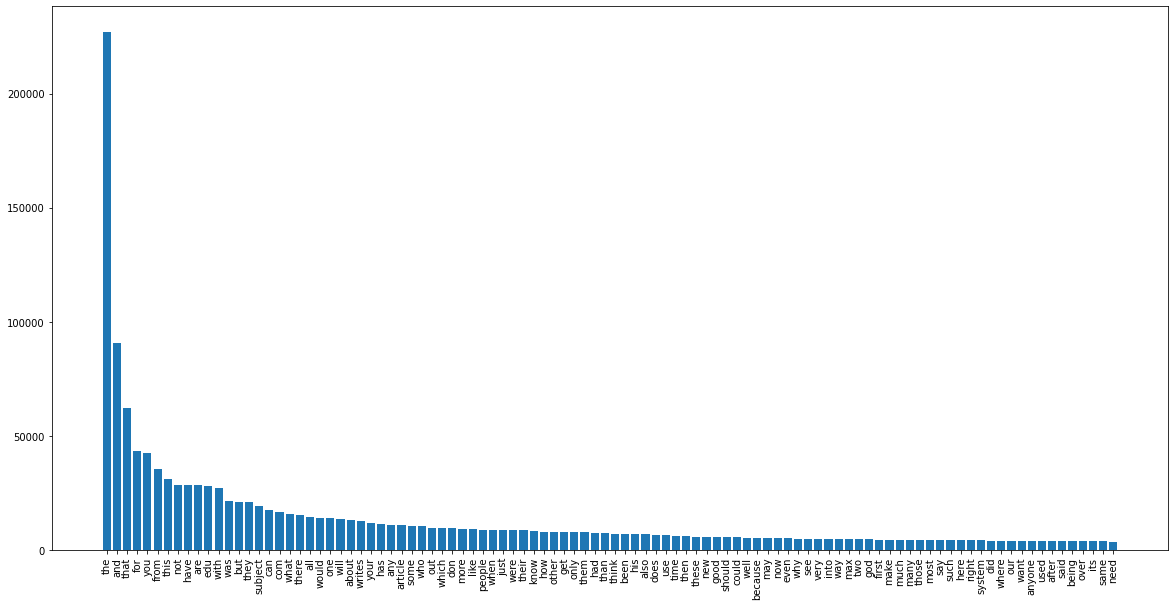

In [ ]:
fig = plt.figure()
fig.set_size_inches(20,10)

plt.bar(range(len(sorted_words[:100])), [v for k, v in sorted_words[:100]] , align='center')
plt.xticks(range(len(sorted_words[:100])), [k for k, v in sorted_words[:100]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### 1.2 Pre-processing to remove most and least frequent words

We can see that different words appear at different frequencies.

The most common words appear in almost all documents. Hence, for a classification task, having information about those words' frequencies does not matter much since they appear frequently in every type of document. To get a good feature representation, we eliminate them since they do not add too much value.

Additionally, notice how the least frequent words appear so rarely that they might not be useful either.

Let us pre-process our news articles now to remove the most frequent and least frequent words by thresholding their counts: 

In [ ]:
valid_words = defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


### 1.3 Bag-of-Words representation

The simplest way to represent a document $D$ as a vector $V$ would be to now count the relevant words in the document. 

For each document, make a vector of the count of each of the words in the vocabulary (excluding the words removed in the previous step - the "stopwords").

In [ ]:
def convert_to_BoW(dataset, number_of_documents):
    bow_representation = np.zeros((number_of_documents, word_vector_size))
    labels = np.zeros((number_of_documents, 1))
    
    i = 0
    for label, class_name in enumerate(dataset):
        
        # For each file
        for f in dataset[class_name]:
            
            # Read all text in file
            text = ' '.join(f).split(' ')
            
            # For each word
            for word in text:
                if word in valid_words:
                    bow_representation[i, valid_words[word]] += 1
            
            # Label of document
            labels[i] = label
            
            # Increment document counter
            i += 1
    
    return bow_representation, labels

# Convert the dataset into their bag of words representation treating train and test separately
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

### 1.4 Document classification using Bag-of-Words after reducing the data using PCA with different no. of principal components

### It will take longer time than expected because of the large dataset, componets size is large and we are trying to classify using Knn

Computing accuracy for the bag-of-words features on the full train set:

In [ ]:
components= [2, 4, 8, 16, 32, 64, 128, 256, 512]
accuracies = []
for i in components:
  pca = PCA(n_components=i) #varying the components
  pca.fit(train_bow_set)  #fitting the training with pca model
  X_train = pca.transform(train_bow_set)
  X_test = pca.transform(test_bow_set)
  clf = KNeighborsClassifier(n_neighbors=3, metric='euclidean') #Using Knn classifier with three nearest neighbours
  clf.fit(X_train, train_bow_labels)
  acc = clf.score(X_train, train_bow_labels)
  accuracies.append(acc)
  print('Accuracy with {} components of PCA is {}'.format(i,acc))

Accuracy with 2 components of PCA is 0.4177760375880971
Accuracy with 4 components of PCA is 0.4424991609799754
Accuracy with 8 components of PCA is 0.5108513256516389
Accuracy with 16 components of PCA is 0.5817764850654435
Accuracy with 32 components of PCA is 0.629320953126748
Accuracy with 64 components of PCA is 0.6530372524890927
Accuracy with 128 components of PCA is 0.6806689786329567
Accuracy with 256 components of PCA is 0.7091956594697394
Accuracy with 512 components of PCA is 0.7229555878733639


###Plotting the graph between number of components vs accuracies

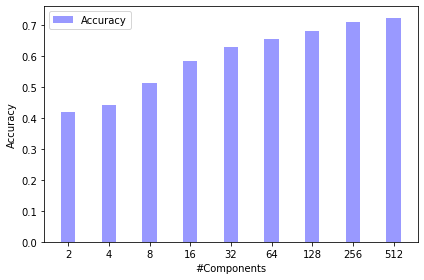

In [ ]:
index = np.arange(len(accuracies))
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(index , accuracies, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Accuracy')
plt.xticks(index, components)
plt.xlabel("#Components")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

There will be decrease in accuracy after 1024 components is due to the noise in the data when more components are added.